In [3]:
!pip install uv
!uv venv llm-scratch
!source /kaggle/working/llm-scratch/bin/activate
!uv pip install -q huggingface tiktoken

Using CPython 3.11.13 interpreter at: /usr/bin/python3
Creating virtual environment at: llm-scratch
Activate with: source llm-scratch/bin/activate


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Loading Dataset

In [3]:
from datasets import load_dataset
def load_bookcorpus():
    book_corpus = load_dataset("bookcorpus", trust_remote_code=True)

    if "train" in book_corpus:
        train_dataset = book_corpus["train"]
        first_example = train_dataset[0]
        key = list(first_example.keys())[0]
        for i in range(100):
            print(train_dataset[i][key])
    else:
        print("The dataset has no training split.")

load_bookcorpus()

README.md: 0.00B [00:00, ?B/s]

bookcorpus.py: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/74004228 [00:00<?, ? examples/s]

KeyboardInterrupt: 

# Simple Self Attention with Trainable Weights

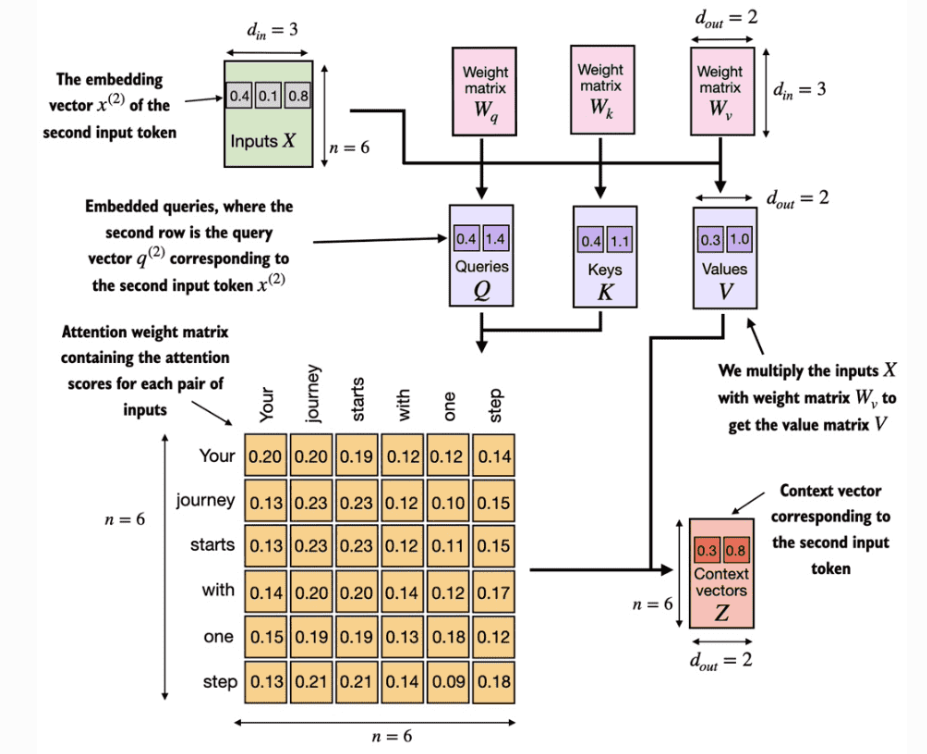

In [5]:
!uv pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128

In [6]:
import torch
import torch.nn as nn

target_query = 1 # Journey

class SelfAttention(nn.Module):
    def __init__(self, d_in=3, d_out=3, qkv_bias=False):
        super().__init__()
        self.d_out = d_out

        # initializing Trainable weights for Query, key and value matrix
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        
        # input matrix @ Query, input matrix @ Keys, input matrix @ Values
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        q_journey = queries[target_query]
        k_journey = keys[target_query]
        v_journey = values[target_query]

        # Computing Attention Scores
        # Queries @ Keys.T
        attn_scores = queries @ keys.T

        # Computing Attention Weights
        # 1. divide by sqrt(k_dim)
        # 2. softmax()
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

        # computing Context Vectors
        # Attention Weights @ Values
        context_vec = attn_weights @ values
        return context_vec, q_journey, k_journey, v_journey, values

In [7]:
torch.manual_seed(47)
test_sentence = torch.rand(6, 3)
print(test_sentence)

tensor([[0.0530, 0.0499, 0.4677],
        [0.8757, 0.5561, 0.7984],
        [0.9758, 0.2482, 0.1469],
        [0.4345, 0.6988, 0.8883],
        [0.2638, 0.2658, 0.1375],
        [0.4610, 0.7439, 0.0351]])


In [8]:
self_attn = SelfAttention()
context_vec, q_journey, k_journey, v_journey, values = self_attn(test_sentence)
q_journey_np = q_journey.detach().cpu().numpy()
k_journey_np = k_journey.detach().cpu().numpy()
v_journey_np = v_journey.detach().cpu().numpy()
values_np = values.detach().cpu().numpy()
context_vec_np = context_vec.detach().cpu().numpy()
print(context_vec)

tensor([[-0.3580, -0.2275, -0.1464],
        [-0.3671, -0.2329, -0.1505],
        [-0.3651, -0.2325, -0.1483],
        [-0.3644, -0.2308, -0.1500],
        [-0.3596, -0.2288, -0.1466],
        [-0.3626, -0.2304, -0.1478]], grad_fn=<MmBackward0>)


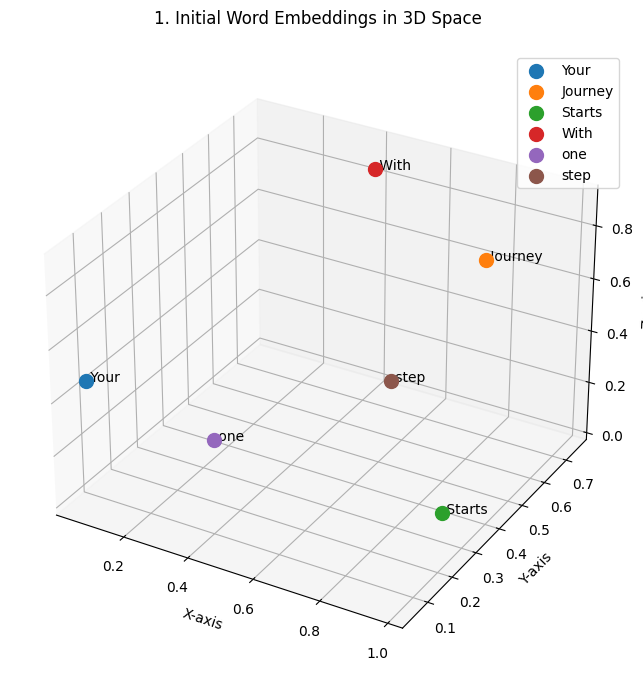

In [9]:
import matplotlib.pyplot as plt

# Word Embeddings plot
fig1 = plt.figure(figsize=(10, 8))
ax1 = fig1.add_subplot(projection='3d')
ax1.set_title("1. Initial Word Embeddings in 3D Space", pad=20)
sentence = ["Your", "Journey", "Starts", "With", "one", "step"]

for i, word in enumerate(sentence):
    ax1.scatter(test_sentence[i, 0], test_sentence[i, 1], test_sentence[i, 2], s=100, label=word)
    ax1.text(test_sentence[i, 0], test_sentence[i, 1], test_sentence[i, 2], f' {word}', size=10, zorder=1, color='k')

ax1.set_xlabel("X-axis")
ax1.set_ylabel("Y-axis")
ax1.set_zlabel("Z-axis")
ax1.legend()

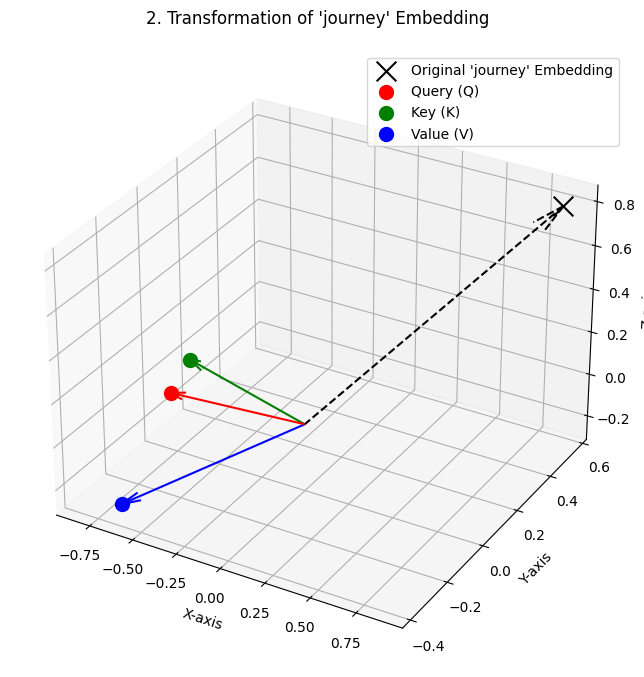

In [10]:
# Query, Key and Value matrix representation in respect to Query="Journey"
fig2 = plt.figure(figsize=(10, 8))
ax2 = fig2.add_subplot(projection='3d')
ax2.set_title("2. Transformation of 'journey' Embedding", pad=20)

# Plot the original embedding
ax2.scatter(test_sentence[target_query, 0], test_sentence[target_query, 1], test_sentence[target_query, 2], s=200, c='black', marker='x', label="Original 'journey' Embedding")
# Plot the transformed Q, K, V vectors
ax2.scatter(q_journey_np[0], q_journey_np[1], q_journey_np[2], s=100, c='r', marker='o', label="Query (Q)")
ax2.scatter(k_journey_np[0], k_journey_np[1], k_journey_np[2], s=100, c='g', marker='o', label="Key (K)")
ax2.scatter(v_journey_np[0], v_journey_np[1], v_journey_np[2], s=100, c='b', marker='o', label="Value (V)")

# Draw arrows from origin for clarity
ax2.quiver(0, 0, 0, test_sentence[target_query, 0], test_sentence[target_query, 1], test_sentence[target_query, 2], color='black', arrow_length_ratio=0.1, linestyle='--')
ax2.quiver(0, 0, 0, q_journey_np[0], q_journey_np[1], q_journey_np[2], color='r', arrow_length_ratio=0.1)
ax2.quiver(0, 0, 0, k_journey_np[0], k_journey_np[1], k_journey_np[2], color='g', arrow_length_ratio=0.1)
ax2.quiver(0, 0, 0, v_journey_np[0], v_journey_np[1], v_journey_np[2], color='b', arrow_length_ratio=0.1)

ax2.set_xlabel("X-axis")
ax2.set_ylabel("Y-axis")
ax2.set_zlabel("Z-axis")
ax2.legend()

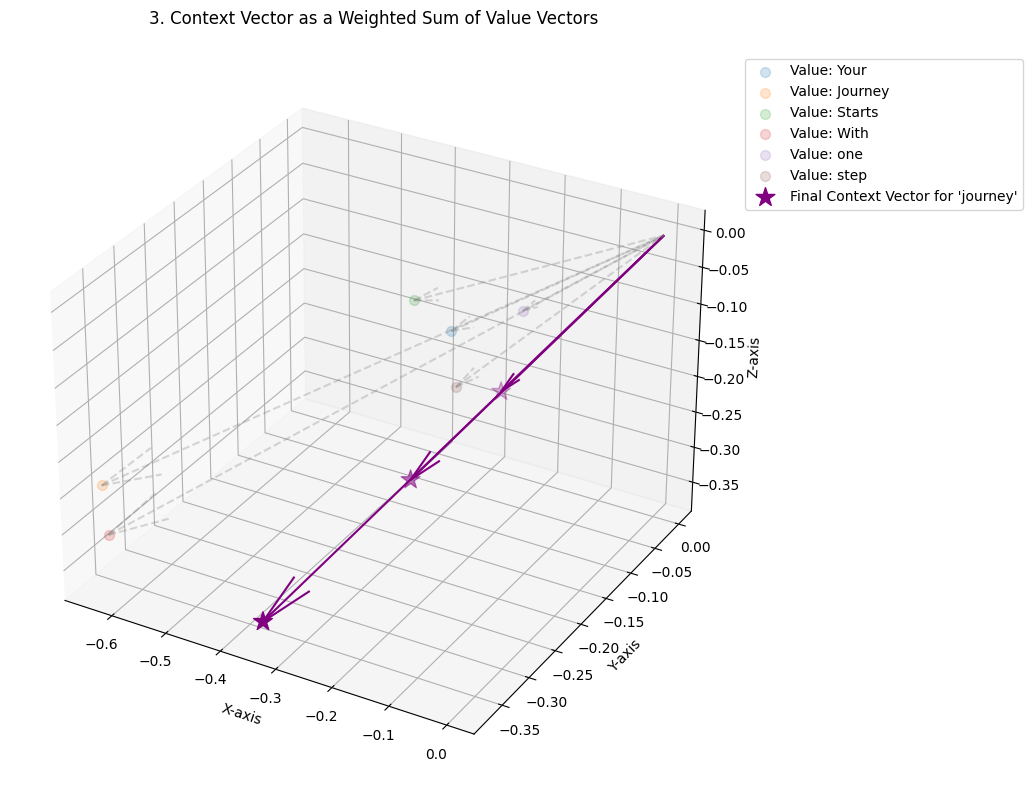

In [11]:
fig3 = plt.figure(figsize=(10, 8))
ax3 = fig3.add_subplot(projection='3d')
ax3.set_title("3. Context Vector as a Weighted Sum of Value Vectors", pad=20)

# Plot all Value vectors (faintly)
for i, word in enumerate(sentence):
    ax3.scatter(values_np[i, 0], values_np[i, 1], values_np[i, 2], s=50, alpha=0.2, label=f"Value: {word}")
    ax3.quiver(0, 0, 0, values_np[i, 0], values_np[i, 1], values_np[i, 2], color='gray', linestyle='--', arrow_length_ratio=0.1, alpha=0.3)

# Plot the final context vector (prominently)
ax3.scatter(context_vec_np[0], context_vec_np[1], context_vec_np[2], s=200, c='purple', marker='*', label="Final Context Vector for 'journey'")
ax3.quiver(0, 0, 0, context_vec_np[0], context_vec_np[1], context_vec_np[2], color='purple', arrow_length_ratio=0.1)

ax3.set_xlabel("X-axis")
ax3.set_ylabel("Y-axis")
ax3.set_zlabel("Z-axis")
ax3.legend(loc='upper left', bbox_to_anchor=(1, 1))
fig3.tight_layout()

# Causal Attention with Trainable Weights
## Causal Attention Implementation strategy:
### 1. Compute Attention Scores:
        i. Queries @ keys.T
### 2. Mask the future tokens
### 3. Compute Attention Weights:
        i. Divide by sqrt(k_dims)
        ii. Softmax
### 4. Compute Context Vector:
        i. Attention Weights @ Values

In [12]:
import torch
import torch.nn as nn

class CausalAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, qkv_bias=False):
        super().__init__()
        self.d_out = d_out

        # intializing trainable query, key and value weights matrix
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        # initializing mask buffer
        self.register_buffer(
            "mask",
            torch.triu(
                torch.ones(context_length, context_length),
                diagonal=1
            )
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        # compute Attention Scores
        # queries @ keys.T
        attn_scores = queries @ keys.transpose(1, 2) # (b, row, column) to (b, column, row)

        # Mask future token weights
        attn_scores.masked_fill(
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf
        )

        # Compute Attention Weights
        # Divide by sqrt(k_dim)
        # softmax()
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

        # Compute Context Vector
        # Attention Weights @ Values
        context_vec = attn_weights @ values
        return context_vec, values

In [13]:
torch.manual_seed(47)
test_sentence = torch.rand(2, 6, 3)
print(test_sentence)
print(test_sentence.shape)

tensor([[[0.0530, 0.0499, 0.4677],
         [0.8757, 0.5561, 0.7984],
         [0.9758, 0.2482, 0.1469],
         [0.4345, 0.6988, 0.8883],
         [0.2638, 0.2658, 0.1375],
         [0.4610, 0.7439, 0.0351]],

        [[0.1422, 0.4056, 0.5341],
         [0.5862, 0.1469, 0.2960],
         [0.2738, 0.7361, 0.9117],
         [0.2284, 0.0591, 0.2135],
         [0.4852, 0.7574, 0.4865],
         [0.0853, 0.8015, 0.7464]]])
torch.Size([2, 6, 3])


In [14]:
context_length = test_sentence.shape[1]
print(f"context_length = {context_length}")
causal_attn = CausalAttention(3, 3, context_length)
context_vec, values = causal_attn(test_sentence)
print(context_vec)

context_length = 6
tensor([[[-0.0482,  0.0265, -0.0655],
         [-0.0510,  0.0293, -0.0694],
         [-0.0480,  0.0271, -0.0655],
         [-0.0514,  0.0291, -0.0699],
         [-0.0477,  0.0262, -0.0649],
         [-0.0486,  0.0269, -0.0662]],

        [[-0.0463,  0.1327, -0.0791],
         [-0.0464,  0.1323, -0.0791],
         [-0.0459,  0.1345, -0.0789],
         [-0.0466,  0.1314, -0.0791],
         [-0.0461,  0.1335, -0.0790],
         [-0.0461,  0.1338, -0.0790]]], grad_fn=<UnsafeViewBackward0>)


# Causal Attention with Dropout
## Causal Attention Implementation strategy:
### 1. Compute Attention Scores:
        i. Queries @ keys.T
### 2. Mask the future tokens
### 3. Compute Attention Weights:
        i. Divide by sqrt(k_dims)
        ii. Softmax
### 4. Dropout
### 5. Compute Context Vector:
        i. Attention Weights @ Values

In [15]:
import torch
import torch.nn as nn

class CausalAttentionWithDropout(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.dropout = nn.Dropout(dropout)

        # initializing Query, Key and Values weight matrix
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        

        # setting mask buffer
        self.register_buffer(
            "mask",
            torch.triu(
                torch.ones(context_length, context_length),
                diagonal=1
            )
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        # computing attention scores
        attn_scores = queries @ keys.transpose(1,2)

        # masking future tokens
        attn_scores.masked_fill(
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf
        )

        # compute attention weights
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

        # DROPOUT
        attn_weights = self.dropout(attn_weights)

        # compute context vector
        context_vec = attn_weights @ values

        return context_vec

In [16]:
torch.manual_seed(47)
test_sentence = torch.rand(5, 6, 3)
print(test_sentence.shape)
print(test_sentence)

torch.Size([5, 6, 3])
tensor([[[5.3048e-02, 4.9919e-02, 4.6767e-01],
         [8.7569e-01, 5.5607e-01, 7.9838e-01],
         [9.7576e-01, 2.4823e-01, 1.4692e-01],
         [4.3449e-01, 6.9878e-01, 8.8831e-01],
         [2.6383e-01, 2.6581e-01, 1.3750e-01],
         [4.6097e-01, 7.4394e-01, 3.5056e-02]],

        [[1.4224e-01, 4.0564e-01, 5.3406e-01],
         [5.8620e-01, 1.4691e-01, 2.9599e-01],
         [2.7384e-01, 7.3611e-01, 9.1173e-01],
         [2.2841e-01, 5.9055e-02, 2.1353e-01],
         [4.8523e-01, 7.5743e-01, 4.8650e-01],
         [8.5262e-02, 8.0155e-01, 7.4638e-01]],

        [[3.5573e-01, 4.0547e-01, 2.8260e-02],
         [4.0705e-01, 3.2965e-01, 3.1501e-01],
         [5.4133e-01, 3.4997e-01, 2.9980e-01],
         [4.5799e-01, 3.4092e-01, 3.9747e-01],
         [3.3840e-01, 3.7927e-01, 1.6479e-01],
         [6.7884e-04, 5.7458e-01, 2.7804e-01]],

        [[4.2036e-01, 7.6008e-01, 2.3162e-01],
         [2.6895e-01, 4.6869e-01, 8.7141e-01],
         [4.3764e-01, 8.0757e-01

In [17]:
context_length = test_sentence.shape[1]
causal_attn = CausalAttentionWithDropout(d_in=3, d_out=3, context_length=context_length, dropout=0.0)
context_vec = causal_attn(test_sentence)
print(context_vec)

tensor([[[-2.0692e-03,  2.4648e-01,  4.5697e-01],
         [ 5.4488e-04,  2.4366e-01,  4.5745e-01],
         [-4.5861e-05,  2.4194e-01,  4.5347e-01],
         [-2.8639e-04,  2.4683e-01,  4.6058e-01],
         [-1.6881e-03,  2.4612e-01,  4.5667e-01],
         [-9.2217e-04,  2.4689e-01,  4.5872e-01]],

        [[-2.7783e-02,  3.2784e-01,  4.8529e-01],
         [-2.7149e-02,  3.2220e-01,  4.7978e-01],
         [-2.7607e-02,  3.2871e-01,  4.8674e-01],
         [-2.7631e-02,  3.2487e-01,  4.8198e-01],
         [-2.7458e-02,  3.2717e-01,  4.8514e-01],
         [-2.7942e-02,  3.3092e-01,  4.8868e-01]],

        [[ 5.6401e-03,  2.0652e-01,  3.3763e-01],
         [ 5.6859e-03,  2.0626e-01,  3.3761e-01],
         [ 5.7296e-03,  2.0608e-01,  3.3755e-01],
         [ 5.7123e-03,  2.0614e-01,  3.3759e-01],
         [ 5.6485e-03,  2.0645e-01,  3.3764e-01],
         [ 5.5562e-03,  2.0688e-01,  3.3778e-01]],

        [[-1.2674e-02,  3.7365e-01,  5.3184e-01],
         [-1.2995e-02,  3.7355e-01,  5.3234e

# Multi-Head Implementation

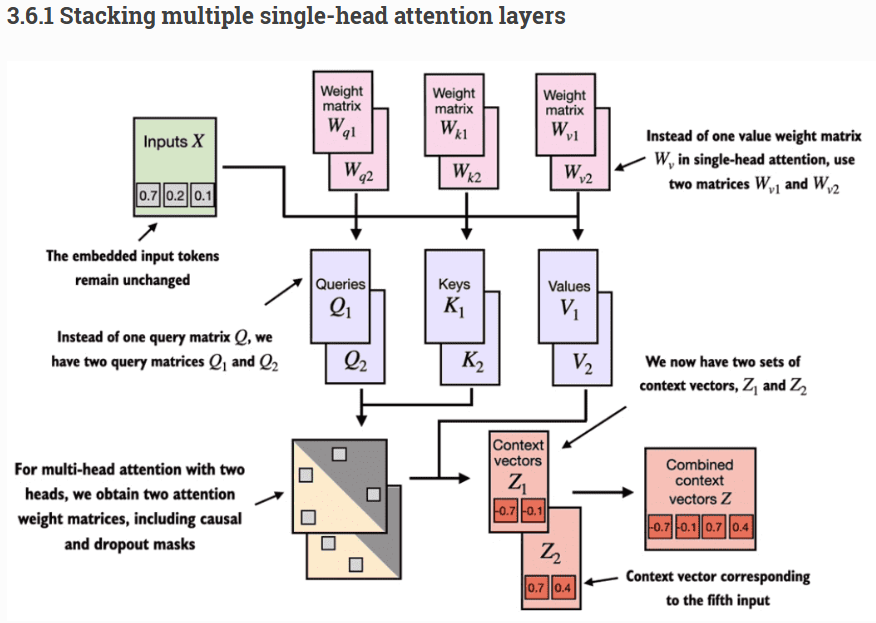

## Multi-Head Attention Wrapper

In [25]:
import torch
import torch.nn as nn

class MultiHeadAttentionWrapper(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        self.heads = nn.ModuleList(
            [CausalAttentionWithDropout(d_in, d_out, context_length, dropout, qkv_bias) for _ in range(num_heads)]
        )

    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim=-1)

In [26]:
torch.manual_seed(47)
test_sentence = torch.rand(5, 6, 3)
print(test_sentence.shape)
print(test_sentence)

torch.Size([5, 6, 3])
tensor([[[5.3048e-02, 4.9919e-02, 4.6767e-01],
         [8.7569e-01, 5.5607e-01, 7.9838e-01],
         [9.7576e-01, 2.4823e-01, 1.4692e-01],
         [4.3449e-01, 6.9878e-01, 8.8831e-01],
         [2.6383e-01, 2.6581e-01, 1.3750e-01],
         [4.6097e-01, 7.4394e-01, 3.5056e-02]],

        [[1.4224e-01, 4.0564e-01, 5.3406e-01],
         [5.8620e-01, 1.4691e-01, 2.9599e-01],
         [2.7384e-01, 7.3611e-01, 9.1173e-01],
         [2.2841e-01, 5.9055e-02, 2.1353e-01],
         [4.8523e-01, 7.5743e-01, 4.8650e-01],
         [8.5262e-02, 8.0155e-01, 7.4638e-01]],

        [[3.5573e-01, 4.0547e-01, 2.8260e-02],
         [4.0705e-01, 3.2965e-01, 3.1501e-01],
         [5.4133e-01, 3.4997e-01, 2.9980e-01],
         [4.5799e-01, 3.4092e-01, 3.9747e-01],
         [3.3840e-01, 3.7927e-01, 1.6479e-01],
         [6.7884e-04, 5.7458e-01, 2.7804e-01]],

        [[4.2036e-01, 7.6008e-01, 2.3162e-01],
         [2.6895e-01, 4.6869e-01, 8.7141e-01],
         [4.3764e-01, 8.0757e-01

In [27]:
d_in = d_out = test_sentence.shape[-1]
context_length = test_sentence.shape[1]
num_heads = 2
dropout = 0.0
print(f"d_in = {d_in}, d_out = {d_out} \ncontext_length = {context_length}")
multihead_attn_wrapper = MultiHeadAttentionWrapper(d_in=d_in, d_out=d_out, context_length=context_length, dropout=dropout, num_heads=num_heads)
context_vec = multihead_attn_wrapper(test_sentence)
print(context_vec)

d_in = 3, d_out = 3 
context_length = 6
tensor([[[-2.0692e-03,  2.4648e-01,  4.5697e-01,  2.4518e-01,  5.0198e-03,
          -8.6172e-02],
         [ 5.4488e-04,  2.4366e-01,  4.5745e-01,  2.4448e-01,  5.5480e-03,
          -8.8810e-02],
         [-4.5861e-05,  2.4194e-01,  4.5347e-01,  2.4490e-01,  6.2273e-03,
          -8.7678e-02],
         [-2.8639e-04,  2.4683e-01,  4.6058e-01,  2.4442e-01,  5.4855e-03,
          -8.9093e-02],
         [-1.6881e-03,  2.4612e-01,  4.5667e-01,  2.4503e-01,  6.0428e-03,
          -8.7262e-02],
         [-9.2217e-04,  2.4689e-01,  4.5872e-01,  2.4457e-01,  7.1117e-03,
          -8.9437e-02]],

        [[-2.7783e-02,  3.2784e-01,  4.8529e-01,  1.1913e-01,  1.3119e-02,
          -2.2869e-01],
         [-2.7149e-02,  3.2220e-01,  4.7978e-01,  1.1924e-01,  1.3347e-02,
          -2.2745e-01],
         [-2.7607e-02,  3.2871e-01,  4.8674e-01,  1.1894e-01,  1.2685e-02,
          -2.3113e-01],
         [-2.7631e-02,  3.2487e-01,  4.8198e-01,  1.1931e-01,  1.35

## Issues with Multi-Head Attention Wrapper
### Multiple heads costs multiple matmul operations causing computation overhead.

## Solution: Multi-Head Attention with Weight Splits.
### Theory:
        1. Initially create a large weight matrix for query, key and value. of dim (d_in, d_out)
        2. input * large weight matrix
        3. Split large weight matrix as per num_heads.
        4. Compute Attention Scores
        5. Mask Future Tokens.
        6. divide by sqrt(head_dim). head_dim = d_out/num_heads
        7. softmax
        8. Compute Attention weights
        9. Dropout
        10. Compute Context Vectors
        11. Combine heads

## All the logic encapsulated in one single class

In [41]:
import torch
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = self.d_out // self.num_heads
        
        # initializing query, key and value large weight matrix of dim(d_in, d_out)
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(
                torch.ones(context_length, context_length),
                diagonal=1
            )
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        # Input * large weight matrix
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        # Split weights matrix according to num_heads
        # achieved by unrolling last dim d_out to num_head, head_dim
        # (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose dim to group tensors by num_heads
        # this helps to compute attention according to heads parallely
        # (b, num_tokens, num_heads, head_dims) -> (b, num_heads, num_tokens, head_dims)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot product attention (aka self-attention) with causal mask
        attn_scores = queries @ keys.transpose(2, 3)

        # mask futuren tokens
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        attn_scores.masked_fill_(
            mask_bool, -torch.inf
        )

        # Compute Attention Weights
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

        # Dropout
        attn_weights = self.dropout(attn_weights)

        # Compute Context Vectors
        # Re-adjust dimension to original dim shape to match d_out
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine all attention heads
        # Where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)

        return context_vec

In [42]:
torch.manual_seed(47)
test_sentence = torch.rand(5, 6, 3)
print(test_sentence.shape)
print(test_sentence)

torch.Size([5, 6, 3])
tensor([[[5.3048e-02, 4.9919e-02, 4.6767e-01],
         [8.7569e-01, 5.5607e-01, 7.9838e-01],
         [9.7576e-01, 2.4823e-01, 1.4692e-01],
         [4.3449e-01, 6.9878e-01, 8.8831e-01],
         [2.6383e-01, 2.6581e-01, 1.3750e-01],
         [4.6097e-01, 7.4394e-01, 3.5056e-02]],

        [[1.4224e-01, 4.0564e-01, 5.3406e-01],
         [5.8620e-01, 1.4691e-01, 2.9599e-01],
         [2.7384e-01, 7.3611e-01, 9.1173e-01],
         [2.2841e-01, 5.9055e-02, 2.1353e-01],
         [4.8523e-01, 7.5743e-01, 4.8650e-01],
         [8.5262e-02, 8.0155e-01, 7.4638e-01]],

        [[3.5573e-01, 4.0547e-01, 2.8260e-02],
         [4.0705e-01, 3.2965e-01, 3.1501e-01],
         [5.4133e-01, 3.4997e-01, 2.9980e-01],
         [4.5799e-01, 3.4092e-01, 3.9747e-01],
         [3.3840e-01, 3.7927e-01, 1.6479e-01],
         [6.7884e-04, 5.7458e-01, 2.7804e-01]],

        [[4.2036e-01, 7.6008e-01, 2.3162e-01],
         [2.6895e-01, 4.6869e-01, 8.7141e-01],
         [4.3764e-01, 8.0757e-01

In [44]:
d_in = d_out = test_sentence.shape[-1]
context_length = test_sentence.shape[1]
num_heads = 3
dropout = 0.2
print(f"d_in = {d_in}, d_out = {d_out} \ncontext_length = {context_length}")
mha = MultiHeadAttention(d_in=d_in, d_out=d_out, context_length=context_length, num_heads=num_heads, dropout=dropout)
context_vec = mha(test_sentence)
print(f"context_vec.shape = {context_vec.shape}")
print(context_vec)

d_in = 3, d_out = 3 
context_length = 6
context_vec.shape = torch.Size([5, 6, 3])
tensor([[[-0.3702,  0.1866, -0.2384],
         [-0.0955,  0.0573, -0.1175],
         [-0.3366,  0.2236, -0.1417],
         [-0.2474,  0.1701, -0.1202],
         [-0.1625,  0.1060, -0.1207],
         [-0.1526,  0.0843, -0.1434]],

        [[-0.1047,  0.0401, -0.1552],
         [-0.1954,  0.1229, -0.1330],
         [-0.1774,  0.1547, -0.0612],
         [-0.1457,  0.0824, -0.1379],
         [-0.1252,  0.0666, -0.1385],
         [-0.0932,  0.0309, -0.1569]],

        [[-0.2607,  0.1525, -0.1651],
         [-0.2313,  0.1393, -0.1501],
         [-0.2182,  0.1343, -0.1428],
         [-0.2724,  0.1655, -0.1577],
         [-0.2740,  0.2011, -0.1037],
         [-0.2225,  0.1180, -0.1732]],

        [[-0.2559,  0.2368, -0.0264],
         [-0.1328,  0.0045, -0.2450],
         [-0.1494,  0.0729, -0.1576],
         [-0.0990,  0.0459, -0.1407],
         [-0.1429,  0.0510, -0.1842],
         [-0.0200, -0.0136, -0.1409]],